In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render li, div.text_cell_render p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

<font size="5" color="red"><b>ch4. 머신러닝 모형 최적화</b></font>
# 1절. 변수 선택과 차원 축소
## 1-1 변수선택과 차원축소
- 종속변수에 영향을 주는 변수들을 찾아 학습에 사용할 독립변수의 수를 줄임
 (어떻게 하면 score를 높일 수 있을지?)
- 과적합과 변수들 사이의 다중공선성(변수들간 강한 상관관계)을 줄일 수 있음
 * 회귀계수 해석이 어려워짐. 모델 예측력이 좋아도 해석력이 떨어짐(어떤 변수가 제일 큰 요인인지 잘), p값이
나 유의성 검정이 왜곡될 수 있음
- 모형의 학습 시간을 줄일 수 있음
- 주성분분석, 상관분석, **분류모형의 feature_importance_, 예측 모형의 coef_**
- SelectKBest : 가장 높은 score에 따라 K개의 특징을 선택
## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 주성분분석은 변수 선택 및 차원축소 방법(기존의 모든 변수를 조합하여 새로운 변수로 만듦) 으로 널리 사용
- 주성분 분석은 상관관계가 있는 변수들을 선형결합해서 **분산이 극대화된 상관관계가 없는 새로운 변수(주성분)
들로 축약**하는 것
- 주성분 분석은 사실 선형대수학이라기보다는 선형대수학의 활용적인 측면이 강하며 영상인식, 통계 데이터분석
(주성분 찾기), 데이터 압축, 노이즈제거 등 여러 분야에 사용
- 영상처리에서 많이 활용 : 여러개의 영상 중 대표 이미지를 찾을 때 활용

In [2]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:, :-1], iris.species
iris_X.shape, iris_y.shape

((150, 4), (150,))

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # n_components : 주성분 갯수
# pca.fit(iris_X)
# pca.transform(iris_X)
iris_pca = pca.fit_transform(iris_X)
iris_pca[:3] # 뽑혀진 주성분 2개

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943]])

In [6]:
import pandas as pd
pd.DataFrame(iris_pca, columns=['pca1', 'pca2']).corr() # 주성분끼리의 상관관계

,pca1,pca2
pca1,1.000000e+00,3.722081e-16
pca2,3.722081e-16,1.000000e+00


In [7]:
# 설명 분산 : 각 주성분이 데이터 분산을 잘 표현하는지 (정보량). 값이 클수록 더 중요한 주성분
pca.explained_variance_

array([4.22824171, 0.24267075])

In [8]:
# 설명 정도 : 0~1사이의 비율로 조정된 값
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [9]:
pca.components_
# 각 주성분의 계수 : 각 주성분이 원래 특성들과 어떤 관계가 있는지 나타내는 가중치
# pca1 = 0.36138659*s_length + -0.08452251*s_width + 0.85667061*p_length + 0.3582892*p_width
# pca2 = 0.65658877*s_length + 0.73016143*s_width + -0.17337266*p_length + -0.07548102*p_width

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

## 1.3 상관관계 확인
- 각 변수들끼리 상관관계를 확인하고 시각화해서 종속변수와 상관관계가 높은 변수들만 선택

In [14]:
import pandas as pd
# redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine = pd.read_csv('data/winequality-red.csv', delimiter=';')
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


cmap의 종류 : 
- https://jrc-park.tistory.com/155
- http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
- http://seaborn.pydata.org/examples/many_pairwise_correlations.html

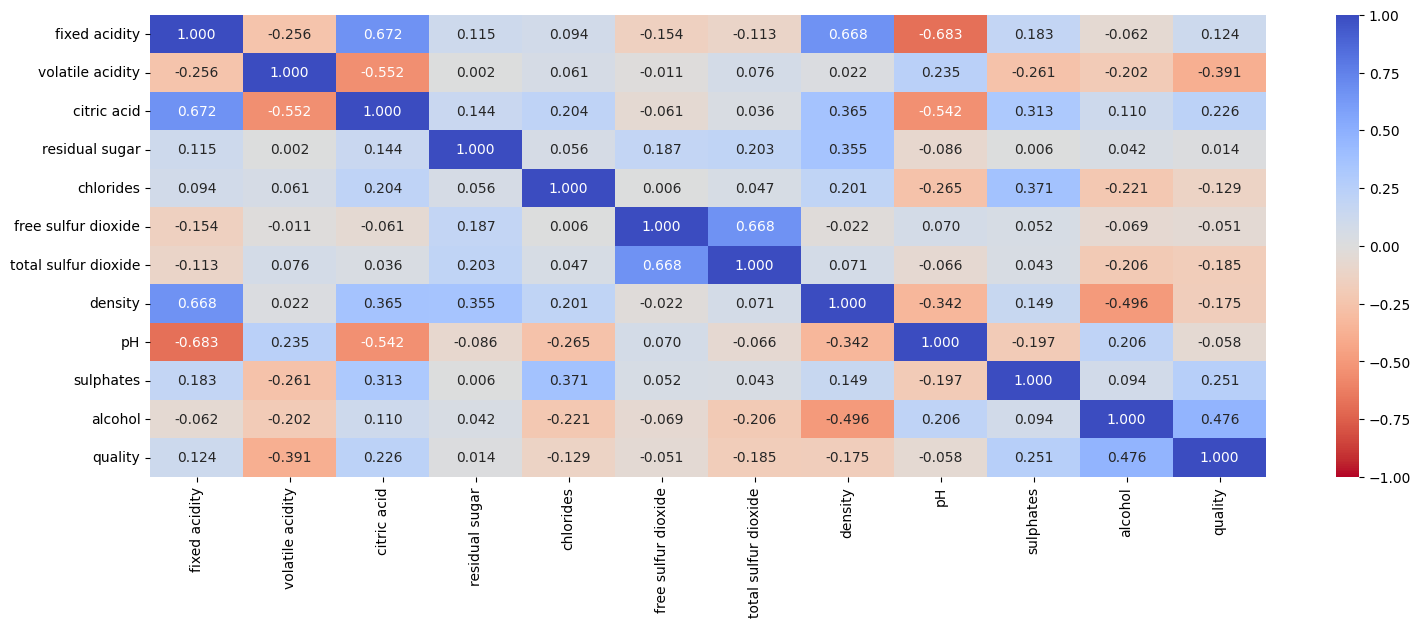

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18,6))
corr = redwine.corr()
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r')
plt.show()

In [27]:
import numpy as np
mask = np.tril(np.ones_like(corr)) # 대각선 포함하여 아래가 1
mask = np.tril(np.ones_like(corr), k=-1) # 대각선 제외하고 아래가 1
mask = np.triu(np.ones_like(corr)) # 대각선 포함하여 위가 1
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

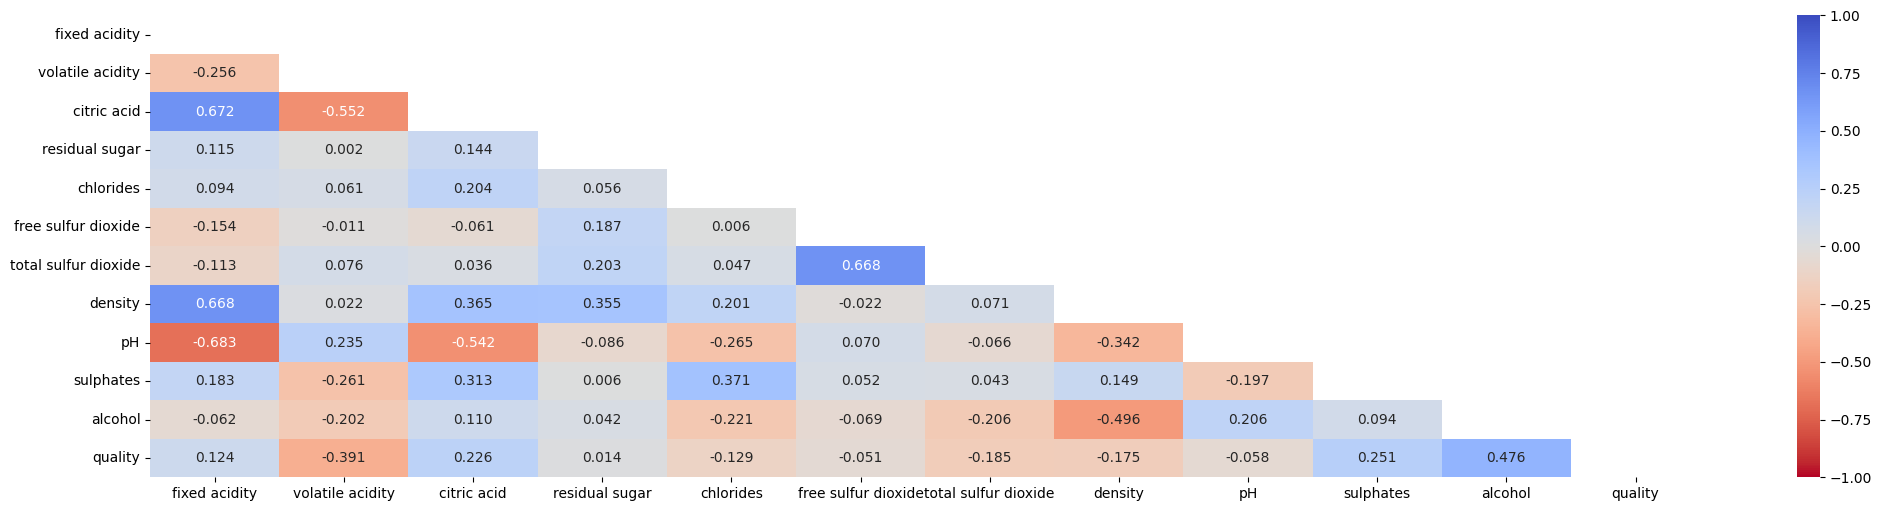

In [29]:
plt.figure(figsize=(25,6))
corr = redwine.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r', mask=mask)
plt.show()

## 1-4 분류모형의 Feature Importance
- 분류모형의 feature_importances_ 속성 : 각 독립변수들이 종속변수에 영향을 주는 정도
- DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier.. (tree계열)
- LogisticRegression, SVC, MLPclassifier등은 feature_importance_속성없음

In [53]:
from sklearn.model_selection import train_test_split
X = redwine.iloc[: , :-1]# .values # numpy배열로
y = redwine.iloc[: , -1]# .to_numpy
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)
train_X.shape, test_X.shape, train_y.shape, test_y.shape, type(train_X)

((1119, 11), (480, 11), (1119,), (480,), pandas.core.frame.DataFrame)

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, # 트리의 갯수 10
                                 random_state=10)
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [55]:
rf_model.score(test_X, test_y) #accuracy

0.6875

In [60]:
rf_model.feature_importances_ # 종속변수에 영향을 주는 정도

array([0.07449613, 0.08987827, 0.07122503, 0.07069328, 0.08448155,
       0.06704734, 0.10858826, 0.09522316, 0.07152949, 0.10705344,
       0.15978406])

In [57]:
features = pd.DataFrame(np.c_[X.columns, rf_model.feature_importances_],
                        columns=['feature', 'importance'])
features['importance'].sum()

1.0000000000000002

In [59]:
features.sort_values(by='importance', ascending=False)

,feature,importance
10,alcohol,0.159784
6,total sulfur dioxide,0.108588
9,sulphates,0.107053
7,density,0.095223
1,volatile acidity,0.089878
4,chlorides,0.084482
0,fixed acidity,0.074496
8,pH,0.071529
2,citric acid,0.071225
3,residual sugar,0.070693


### feature_importances_를 이용한 변수 중요도 시각화

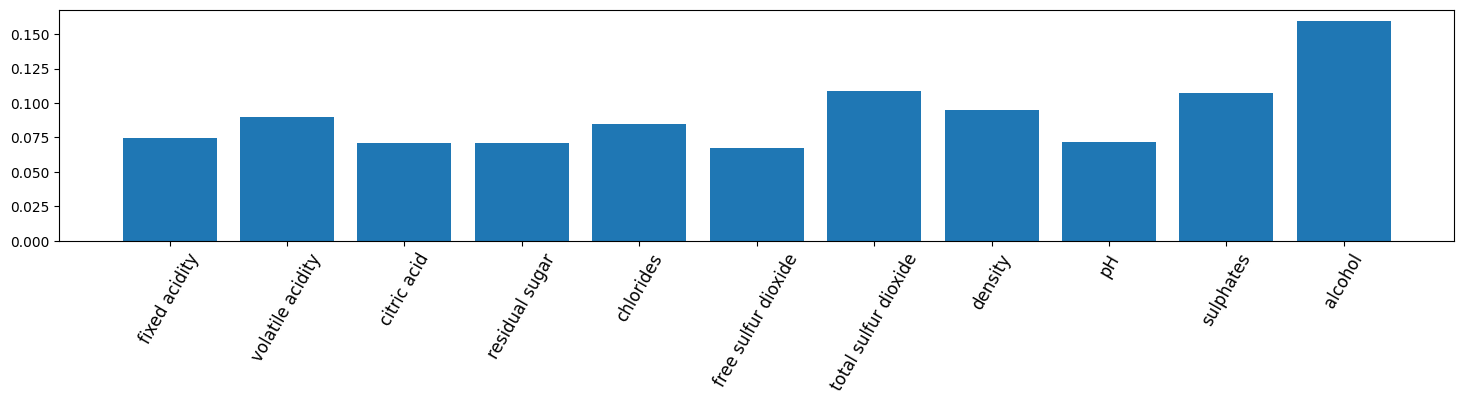

In [65]:
# features를 시각화
plt.figure(figsize=(18,3))
plt.bar(features.feature, features.importance)
plt.xticks(fontsize=12, rotation= 60)
plt.show()

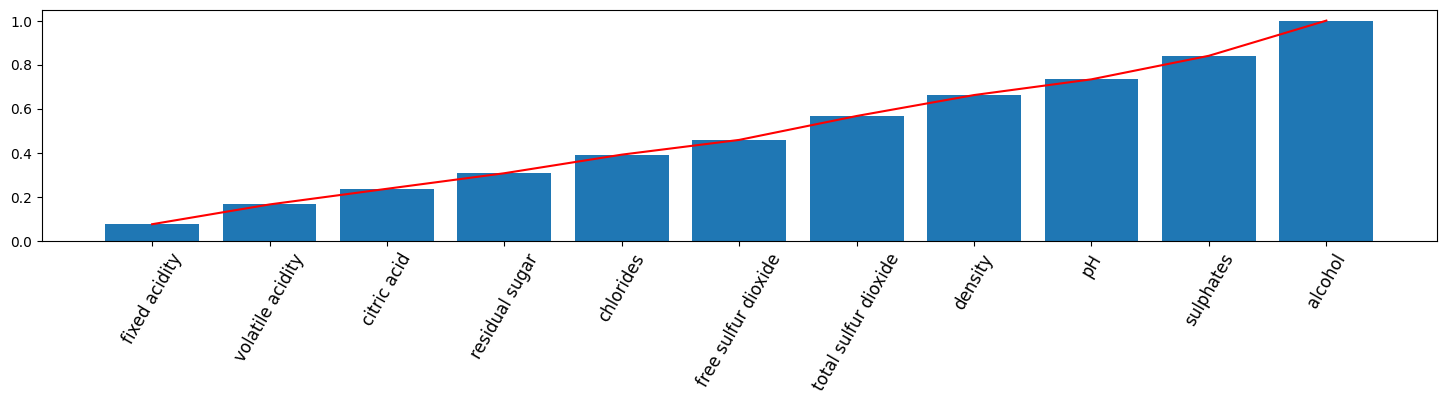

In [67]:
# 누적합을 이용한 시각화
y_stack = np.cumsum(features.importance)
plt.figure(figsize=(18,3))
plt.bar(features.feature, y_stack)
plt.plot(features.feature, y_stack, color="red")
plt.xticks(fontsize=12, rotation= 60)
plt.show()

### RFE(Recursive Feature Elimination) 방식
- RFE를 이용하면 중요도에 따라 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택한 변수를 찾는다

In [68]:
from sklearn.feature_selection import RFE
rfe_model = RFE(# RandomForestClassifier(n_estimators=10,random_state=10)
                rf_model,
                n_features_to_select=5)
rfe_model.fit(train_X, train_y)
rfe_model.get_support() # 선택된 변수(True)인지 제거된 변수(False)인지 여부

array([False,  True, False, False,  True, False,  True, False, False,
        True,  True])

In [71]:
feature_rfe = pd.DataFrame(np.c_[X.columns, rfe_model.get_support()],
                           columns=['feature', 'selected'])
feature_rfe[feature_rfe.selected==True]

,feature,selected
1,volatile acidity,True
4,chlorides,True
6,total sulfur dioxide,True
9,sulphates,True
10,alcohol,True


## 1.5 SelectKBest
- 가장 높은 score에 따라 k개 특징 변수 선택

In [81]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, f_classif, chi2
# f_classif() : ANNOVA F검정 : 독립변수가 연속형(그룹간 차이가 유의미한지)
# chi2        : 카이제곱 통계량 검정 - 독립변수가 범주형(타겟변수도 범주형) 또는 양의 실수
X, y = load_iris(return_X_y=True, as_frame=False)
X.shape, y.shape
X_new = SelectKBest(f_classif, k=1).fit_transform(X, y)

In [82]:
X_new[:3] # petal_length

array([[1.4],
       [1.4],
       [1.3]])

In [84]:
X[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

# 2절 파라미터 탐색
- 하이퍼 파라미터(모델의 성능에 영향을 미칠 수 있는 사용자가 직접 설정하는 파라미터).
- 어떤 파라미터를 사용하는데 최적의 결과를 낼지 탐색
- sklearn패키지의 하이퍼 파라미터 튜닝도구
     * validation_curve() : 단일 하이퍼 파라미터 최적화 함수
     * GridSearchCV : 복수 하이퍼파라미터 최적화 클래스
## 2-1 validation_curve
    - 모형, X, y param_name(파라미터이름), param_range(파라미터값list), 교차검증, scoring 기준

In [135]:
# 데이터
from sklearn.datasets import load_digits
digits = load_digits()
# digits.data 1797x64 크기의 배열
# digits.target : 1797 크기의 배열
# digits.images.shape 1797x8x8 크기의 배열(이미지 형태)
X, y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [136]:
X[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

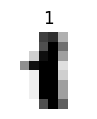

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.imshow(X[1].reshape(8,8), cmap='gray_r')
plt.axis('off')
plt.title(y[1])
plt.show()

In [138]:
from sklearn.svm import SVC
model = SVC(probability=True).fit(X,y)  # 기본 파라미터로 모형 생성

In [139]:
test_x = X[0].reshape(1,-1)
print('예측 :', model.predict(test_x), ' , 실제 :', y[0])

예측 : [0]  , 실제 : 0


In [140]:
prob = model.predict_proba(test_x)[0]
classes = model.classes_
#print('분류 :', classes)
#print('확률 :', prob)
for c, p in zip(classes, prob):
    print("{}일 확률 : {:.3f}%".format(c,p*100))

0일 확률 : 99.131%
1일 확률 : 0.019%
2일 확률 : 0.043%
3일 확률 : 0.086%
4일 확률 : 0.061%
5일 확률 : 0.140%
6일 확률 : 0.075%
7일 확률 : 0.091%
8일 확률 : 0.075%
9일 확률 : 0.278%


In [141]:
# 파라미터 탐색 score (accuracy)
model.score(X,y)

0.996661101836394

In [142]:
# SVC() 모형의 최적의 gamma값 탐색
param_range = np.logspace(-6, -1, 10) # gamma값의 후보군
param_range 

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [143]:
%%time
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(
                                SVC(), # 예측모형
                                X, y,
                                param_name="gamma", # gamma가 크면 결정경계가 복잡. overfitting 위험
                                param_range=param_range,
                                cv=10, # 교차검증
                                scoring="accuracy", # balanced_accuracy(불균형을 고려한 정확도)
                                n_jobs=-1 # 모든 코어
)

CPU times: total: 312 ms
Wall time: 9.09 s


In [144]:
test_scores.shape, train_scores.shape

((10, 10), (10, 10))

In [145]:
test_scores

array([[0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.29608939, 0.19553073, 0.19553073],
       [0.67777778, 0.74444444, 0.7       , 0.66666667, 0.73333333,
        0.67222222, 0.72222222, 0.70949721, 0.67597765, 0.73743017],
       [0.87777778, 0.95      , 0.90555556, 0.86666667, 0.92222222,
        0.91666667, 0.96666667, 0.93854749, 0.83240223, 0.91061453],
       [0.92222222, 0.96666667, 0.95      , 0.91111111, 0.95      ,
        0.98333333, 0.97777778, 0.96648045, 0.87709497, 0.92178771],
       [0.93888889, 0.97222222, 0.93333333, 0.95      , 0.97222222,
        0.98888889, 0.98333333, 0.99441341, 0.91061453, 0.94413408],
       [0.95555556, 1.        , 0.93333333, 0.96666667, 0.98888889,
        0.98888889, 0.99444444, 0.99441341, 0.96089385, 0.96648045],
       [0.93333333, 0.98888889, 0.95555556, 0.96666667, 0.98333333,
        0.98888889, 0.99444444, 0.99441341, 0.97765363, 0.96648045],
       [0.77777778, 0.89444444, 0.7611111

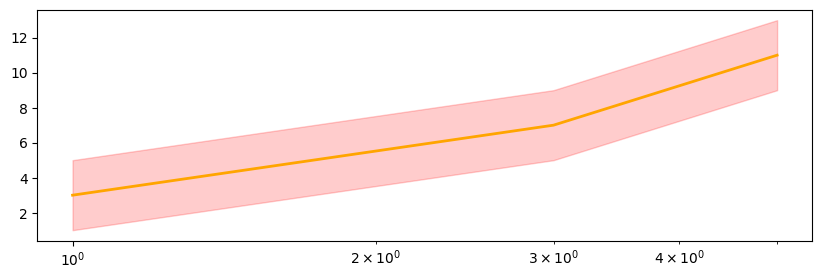

In [146]:
a = np.array([1,3,5]) # 10의 1승, 10의 3승, 10의 5승
b = np.array([3,7,11]) # 3, 7, 11
plt.figure(figsize=(10,3))
plt.semilogx(a, b, color='orange', lw=2)
plt.fill_between(a, b-2, b+2, color='red', alpha=0.2)

In [147]:
train_scores_mean = np.mean(train_scores, axis=1) # train 평균
train_scores_std = np.std(train_scores, axis=1) # train 표준편차
test_scores_mean = test_scores.mean(axis=1) # test 평균
test_scores_std = test_scores.std(axis=1) # test 표준편차

In [148]:
train_scores_mean

array([0.13836306, 0.72045751, 0.93439655, 0.96939318, 0.98775736,
       0.99789765, 1.        , 1.        , 1.        , 1.        ])

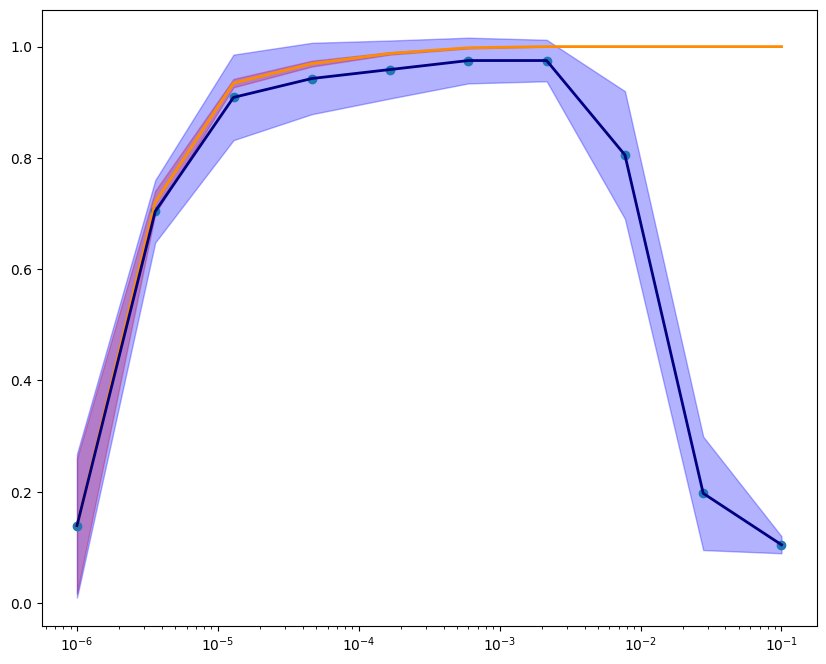

In [149]:
plt.figure(figsize=(10,8))
plt.semilogx(param_range, train_scores_mean, color='darkorange', lw=2)
plt.fill_between(param_range,
                 train_scores_mean-train_scores_std*2,
                 train_scores_mean+train_scores_std*2,
                 alpha=0.3, color='red')
plt.semilogx(param_range, test_scores_mean, color='navy', lw=2)
plt.fill_between(param_range,
                 test_scores_mean-test_scores_std*2,
                 test_scores_mean+test_scores_std*2,
                 alpha=0.3, color='blue')
plt.scatter(param_range, test_scores_mean)
plt.show()

In [150]:
test_scores_mean.argmax()

6

In [151]:
# 최적의 gamma
gamma = param_range[test_scores_mean.argmax()]
gamma

0.0021544346900318843

In [152]:
model = SVC(gamma=gamma).fit(X,y)

In [153]:
model.score(X, y)

1.0

## 2-2 GridSearchCV
- 복수 하이퍼파라미터 최적화 클래스
- 모형 클래스를 가지고 있음
- fit() / predict() / score() / predict_proba() / predict_log_proba()

In [154]:
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine_X = redwine.iloc[:, :-1]
redwine_y = redwine.iloc[:, -1]
redwine_X.shape, redwine_y.shape

((1599, 11), (1599,))

In [155]:
# 가장 평가 점수가 높은 독립변수 ?개 선택, SVC()모형의 최적의 C=?
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC

In [156]:
%%time
# 가장 평가 점수가 높은 독립변수 ?개 선택, SVC()모형의 최적의 C=?
selection = SelectKBest(k=1) # 가장 평가 점수가 높은 k개를 찾음
svc = SVC(kernel='linear', C=0.1) # 직선으로 나누는 가장 단순한 decision_function
pipeline = Pipeline([('select',selection),('svc',svc)])
param_grid = dict(select__k=[5,6,7,8,9,10,11],
                  svc__C=[0.1,1,10])
grid_search = GridSearchCV(pipeline,
                           param_grid=param_grid, # 파라미터들
                           cv=2, # 교차검증 k-fold cross validation
                           verbose=2,
                           n_jobs=-1)
grid_search.fit(redwine_X,redwine_y)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
CPU times: total: 12.9 s
Wall time: 1min 26s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('select', SelectKBest(k=1)),
                                       ('svc', SVC(C=0.1, kernel='linear'))]),
             n_jobs=-1,
             param_grid={'select__k': [5, 6, 7, 8, 9, 10, 11],
                         'svc__C': [0.1, 1, 10]},
             verbose=2)

In [157]:
print(grid_search.best_estimator_) # 가장 높은 점수를 낸 파라미터 모형

Pipeline(steps=[('select', SelectKBest(k=9)),
                ('svc', SVC(C=1, kernel='linear'))])


In [158]:
print(grid_search.best_params_) # 최적의 파라미터 정보

{'select__k': 9, 'svc__C': 1}


In [159]:
model = grid_search.best_estimator_
model.predict(redwine_X)

array([5, 5, 5, ..., 6, 5, 6], dtype=int64)

In [160]:
# 최적의 k값과 c값의 model
model.score(redwine_X, redwine_y)

0.5872420262664165

In [161]:
# 기본 SVC model
model = SVC().fit(redwine_X, redwine_y)
model.score(redwine_X, redwine_y)

0.5103189493433395

# 3절 자료 불균형 처리
- 단순 오버/언더 샘플링
- 단, 단순 오버샘플시 소스의 데이터를 복사하면 그 데이터들에 의해 과적합 생길 수 있음
- SMOTE 라이브러리를 이용한 오버샘플링
## 3-1 SMOTE를 이용한 오버샘플링

In [176]:
# 데이터 (99%:1%)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000,
                           n_features=10, # 독립변수 갯수
                           n_informative=5, # 종속변수에 영향을 주는 갯수
                           n_redundant=0,
                           n_clusters_per_class=1, # 클래스당 서브 클러스터 수
                           n_classes=2,
                           weights=[0.99, 0.01], # 각 클래스의 할당된 표본 확률
                           random_state=42)
X.shape, y.shape, y.sum()

((10000, 10), (10000,), 140)

In [177]:
# train-test 셋 분리 => SMOTE => 모델 fit(train데이터) => score(test데이터)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 10), (3000, 10), (7000,), (3000,))

In [178]:
print(y_train.mean()) # 1이 1.4%
pd.Series(y_train).value_counts()

0.014


0    6902
1      98
dtype: int64

In [179]:
# SMOTE(train데이터)
# pip install imbalanced-learn==0.10.1
from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy={0:6902, 1:600})
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train,y_train)

In [184]:
pd.Series(y_resampled).value_counts()

0    6902
1    6902
dtype: int64

## 3-2 가중치 제어 모형
- 자료 불균형 처리의 또 다른 방법
- 모델에 데이터 따른 가중치 부여 방법

In [185]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight={0:1, 1:1.5}, # 가중치 부여
                                  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.5}, random_state=42)

# 4절. 앙상블 모형 
- 목적 : 여러개 분류 모델을 하나의 통합 분류모델로 연결하여 개별 분류모델보다 더 좋은 성능 달성
- 방법:
    - 배깅(bagging) : 분류를 잘하는 모델에 가중치 (병렬작업) ex.RandomForest
    - 부스팅(boosting) : 분류가 안된 데이터에 가중치(순차작업) ex. XGBoost, LGBM, AdaBoost-불균형데이터
    - 투표(voting) : 여러개 모델의 다수결투표

cf. 배경 알고리즘시 0.632규칙 : 복원 추출시 63.2% 추출 

In [189]:
np.random.choice(10,10, replace=True) # 복원 추출로 10미만의 수를 10개 추출

array([2, 3, 6, 9, 4, 9, 6, 0, 9, 2])

In [201]:
# 10미만의 수 10개 복원추출할 경우 뽑히는 수의 갯수
len(set(np.random.choice(10,10, replace=True)))

7

In [202]:
# 1000미만의 수 1000개 복원추출할 경우 뽑히는 수의 갯수
len(set(np.random.choice(1000,1000, replace=True)))

641

In [204]:
# n미만의 수 n개 복원추출할 경우의 데이터 퍼센트
n=1000000
len(set(np.random.choice(n,n, replace=True)))/n

0.63242

In [205]:
# 데이터
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000,
                           n_features=10,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           n_classes=2,
                           weights=[0.9,0.1],
                           random_state=42)

In [206]:
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
sm=SMOTE()
resampled_X, resampled_y = sm.fit_resample(train_X, train_y)
resampled_X.shape, resampled_y.shape

((12560, 10), (12560,))

In [214]:
from sklearn.metrics import precision_score, recall_score, f1_score
def model_measure(model, train_X=resampled_X, train_y=resampled_y, test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    accuracy = model.score(test_X, test_y)
    hat_y = model.predict(test_X)
    precision = precision_score(test_y, hat_y)
    recall = recall_score(test_y, hat_y)
    f1 = f1_score(test_y, hat_y)
    print(f"정확도 :{accuracy:.4f}, precision:{precision:.4f}, recall:{recall:.4f}, f1:{f1:.4f}")

## 4-1 배깅
- RandomForestClassifier, BaggingClassifier

In [215]:
# 배깅
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model_measure(model)

정확도 :0.9860, precision:0.9555, recall:0.9058, f1:0.9300


In [216]:
from sklearn.ensemble import BaggingClassifier
model_measure(BaggingClassifier(n_estimators=200, bootstrap=True)) # 복원추출

정확도 :0.9860, precision:0.9524, recall:0.9091, f1:0.9302


## 4-2 부스팅
- AdaBoost, XGB, LightGBM, CatBoost

In [220]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [218]:
model_measure(AdaBoostClassifier())

정확도 :0.9800, precision:0.8899, recall:0.9188, f1:0.9042


In [221]:
model_measure(XGBClassifier())

정확도 :0.9857, precision:0.9522, recall:0.9058, f1:0.9285


In [224]:
model_measure(LGBMClassifier(force_col_wise=True))

[LightGBM] [Info] Number of positive: 6280, number of negative: 6280
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 12560, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
정확도 :0.9853, precision:0.9521, recall:0.9026, f1:0.9267


In [223]:
model_measure(CatBoostClassifier())

Learning rate set to 0.030353
0:	learn: 0.6293859	total: 158ms	remaining: 2m 38s
1:	learn: 0.5710178	total: 164ms	remaining: 1m 21s
2:	learn: 0.5243929	total: 170ms	remaining: 56.4s
3:	learn: 0.4758356	total: 175ms	remaining: 43.6s
4:	learn: 0.4298826	total: 181ms	remaining: 36s
5:	learn: 0.3898114	total: 187ms	remaining: 30.9s
6:	learn: 0.3566066	total: 192ms	remaining: 27.3s
7:	learn: 0.3251999	total: 198ms	remaining: 24.6s
8:	learn: 0.2989211	total: 204ms	remaining: 22.4s
9:	learn: 0.2785155	total: 210ms	remaining: 20.8s
10:	learn: 0.2597187	total: 217ms	remaining: 19.5s
11:	learn: 0.2402985	total: 224ms	remaining: 18.4s
12:	learn: 0.2240052	total: 231ms	remaining: 17.5s
13:	learn: 0.2112480	total: 237ms	remaining: 16.7s
14:	learn: 0.1980560	total: 242ms	remaining: 15.9s
15:	learn: 0.1874424	total: 249ms	remaining: 15.3s
16:	learn: 0.1767491	total: 255ms	remaining: 14.7s
17:	learn: 0.1651102	total: 261ms	remaining: 14.2s
18:	learn: 0.1548567	total: 266ms	remaining: 13.8s
19:	learn: 

175:	learn: 0.0357806	total: 1.24s	remaining: 5.81s
176:	learn: 0.0357143	total: 1.25s	remaining: 5.8s
177:	learn: 0.0355037	total: 1.25s	remaining: 5.8s
178:	learn: 0.0354499	total: 1.26s	remaining: 5.78s
179:	learn: 0.0352697	total: 1.27s	remaining: 5.77s
180:	learn: 0.0351778	total: 1.27s	remaining: 5.76s
181:	learn: 0.0349815	total: 1.28s	remaining: 5.75s
182:	learn: 0.0348602	total: 1.28s	remaining: 5.74s
183:	learn: 0.0346894	total: 1.29s	remaining: 5.73s
184:	learn: 0.0345793	total: 1.3s	remaining: 5.72s
185:	learn: 0.0344986	total: 1.3s	remaining: 5.71s
186:	learn: 0.0344145	total: 1.31s	remaining: 5.7s
187:	learn: 0.0342102	total: 1.31s	remaining: 5.68s
188:	learn: 0.0340608	total: 1.32s	remaining: 5.67s
189:	learn: 0.0339461	total: 1.33s	remaining: 5.66s
190:	learn: 0.0337555	total: 1.33s	remaining: 5.65s
191:	learn: 0.0335751	total: 1.34s	remaining: 5.64s
192:	learn: 0.0333835	total: 1.35s	remaining: 5.63s
193:	learn: 0.0331301	total: 1.35s	remaining: 5.62s
194:	learn: 0.032

365:	learn: 0.0197836	total: 2.47s	remaining: 4.28s
366:	learn: 0.0197121	total: 2.48s	remaining: 4.28s
367:	learn: 0.0197037	total: 2.48s	remaining: 4.27s
368:	learn: 0.0196279	total: 2.49s	remaining: 4.26s
369:	learn: 0.0194927	total: 2.5s	remaining: 4.25s
370:	learn: 0.0194846	total: 2.5s	remaining: 4.25s
371:	learn: 0.0193857	total: 2.51s	remaining: 4.24s
372:	learn: 0.0193244	total: 2.52s	remaining: 4.23s
373:	learn: 0.0192710	total: 2.52s	remaining: 4.22s
374:	learn: 0.0192524	total: 2.53s	remaining: 4.21s
375:	learn: 0.0191869	total: 2.54s	remaining: 4.21s
376:	learn: 0.0191146	total: 2.54s	remaining: 4.2s
377:	learn: 0.0190403	total: 2.55s	remaining: 4.19s
378:	learn: 0.0190072	total: 2.55s	remaining: 4.18s
379:	learn: 0.0189922	total: 2.56s	remaining: 4.18s
380:	learn: 0.0189818	total: 2.56s	remaining: 4.17s
381:	learn: 0.0189539	total: 2.57s	remaining: 4.16s
382:	learn: 0.0188865	total: 2.58s	remaining: 4.15s
383:	learn: 0.0188374	total: 2.58s	remaining: 4.14s
384:	learn: 0.0

534:	learn: 0.0136933	total: 3.5s	remaining: 3.04s
535:	learn: 0.0136791	total: 3.5s	remaining: 3.03s
536:	learn: 0.0136156	total: 3.51s	remaining: 3.03s
537:	learn: 0.0136133	total: 3.52s	remaining: 3.02s
538:	learn: 0.0135776	total: 3.52s	remaining: 3.01s
539:	learn: 0.0135704	total: 3.53s	remaining: 3.01s
540:	learn: 0.0135615	total: 3.54s	remaining: 3s
541:	learn: 0.0135592	total: 3.54s	remaining: 2.99s
542:	learn: 0.0135571	total: 3.55s	remaining: 2.98s
543:	learn: 0.0135362	total: 3.55s	remaining: 2.98s
544:	learn: 0.0135324	total: 3.56s	remaining: 2.97s
545:	learn: 0.0135129	total: 3.56s	remaining: 2.96s
546:	learn: 0.0135076	total: 3.57s	remaining: 2.96s
547:	learn: 0.0134727	total: 3.58s	remaining: 2.95s
548:	learn: 0.0134203	total: 3.58s	remaining: 2.94s
549:	learn: 0.0134001	total: 3.59s	remaining: 2.93s
550:	learn: 0.0133713	total: 3.59s	remaining: 2.93s
551:	learn: 0.0133358	total: 3.6s	remaining: 2.92s
552:	learn: 0.0133118	total: 3.6s	remaining: 2.91s
553:	learn: 0.01329

702:	learn: 0.0100449	total: 4.52s	remaining: 1.91s
703:	learn: 0.0100154	total: 4.53s	remaining: 1.9s
704:	learn: 0.0100063	total: 4.54s	remaining: 1.9s
705:	learn: 0.0099936	total: 4.54s	remaining: 1.89s
706:	learn: 0.0099829	total: 4.55s	remaining: 1.88s
707:	learn: 0.0099696	total: 4.55s	remaining: 1.88s
708:	learn: 0.0099612	total: 4.56s	remaining: 1.87s
709:	learn: 0.0099584	total: 4.57s	remaining: 1.86s
710:	learn: 0.0099435	total: 4.57s	remaining: 1.86s
711:	learn: 0.0099224	total: 4.58s	remaining: 1.85s
712:	learn: 0.0099154	total: 4.58s	remaining: 1.84s
713:	learn: 0.0099000	total: 4.59s	remaining: 1.84s
714:	learn: 0.0098877	total: 4.59s	remaining: 1.83s
715:	learn: 0.0098508	total: 4.6s	remaining: 1.82s
716:	learn: 0.0098004	total: 4.61s	remaining: 1.82s
717:	learn: 0.0097836	total: 4.61s	remaining: 1.81s
718:	learn: 0.0097597	total: 4.62s	remaining: 1.8s
719:	learn: 0.0097255	total: 4.62s	remaining: 1.8s
720:	learn: 0.0097186	total: 4.63s	remaining: 1.79s
721:	learn: 0.009

881:	learn: 0.0077226	total: 5.53s	remaining: 740ms
882:	learn: 0.0077226	total: 5.54s	remaining: 734ms
883:	learn: 0.0077226	total: 5.54s	remaining: 728ms
884:	learn: 0.0077226	total: 5.55s	remaining: 721ms
885:	learn: 0.0077225	total: 5.55s	remaining: 715ms
886:	learn: 0.0077225	total: 5.56s	remaining: 709ms
887:	learn: 0.0077225	total: 5.57s	remaining: 702ms
888:	learn: 0.0077225	total: 5.57s	remaining: 696ms
889:	learn: 0.0077225	total: 5.58s	remaining: 689ms
890:	learn: 0.0077225	total: 5.58s	remaining: 683ms
891:	learn: 0.0077225	total: 5.58s	remaining: 676ms
892:	learn: 0.0077225	total: 5.59s	remaining: 670ms
893:	learn: 0.0077225	total: 5.59s	remaining: 663ms
894:	learn: 0.0077225	total: 5.6s	remaining: 657ms
895:	learn: 0.0077225	total: 5.6s	remaining: 651ms
896:	learn: 0.0077224	total: 5.61s	remaining: 644ms
897:	learn: 0.0077224	total: 5.61s	remaining: 638ms
898:	learn: 0.0077224	total: 5.62s	remaining: 631ms
899:	learn: 0.0077224	total: 5.62s	remaining: 625ms
900:	learn: 0.